In [1]:
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
#renaming winPlaceClass with label
data = data.withColumnRenamed('winPlaceClass', 'label')
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('label', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('hasDisconnected', 'int'),
 ('assist_SUM', 'int'),
 ('assist_MAX', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_MAX', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_MAX', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_MAX', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_MAX', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_MAX', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_MAX', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_MAX', 'double'),
 ('distance_AVG', 'double'),
 ('rideDistance_SU

In [3]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'label']
inputCols = list(set(inputCols) - set(toRemove))

In [32]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [33]:
seed = 42
withReplacement=False
output = output.sample(withReplacement, 0.1, seed).select("features", "label")

(training,testing) = output.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 140650
testing: 60782


In [34]:
training.groupBy('label').count().toPandas()

,label,count
0,1,3331
1,6,3300
2,3,32781
3,5,33439
4,4,34693
5,2,33106


Gradient Boosted Trees supporta solo la classificazione binaria in pyspark, si creano 6 modelli GBT per ogni classe usando OneVsRest Classifier.

In [46]:
gbt = GBTClassifier(maxIter=100, maxDepth=5, labelCol="label", seed=42)
ovr = OneVsRest(classifier=gbt)
model = ovr.fit(training)

In [47]:
predictions = model.transform(testing)

In [48]:
model.models

[GBTClassificationModel: uid = GBTClassifier_db5590f62611, numTrees=100, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_db5590f62611, numTrees=100, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_db5590f62611, numTrees=100, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_db5590f62611, numTrees=100, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_db5590f62611, numTrees=100, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_db5590f62611, numTrees=100, numClasses=2, numFeatures=51,
 GBTClassificationModel: uid = GBTClassifier_db5590f62611, numTrees=100, numClasses=2, numFeatures=51]

In [83]:
features_importances = pd.Series(0, index=inputCols)

for m in model.models:
    features_importances = features_importances.add( pd.Series(m.featureImportances.toArray(), index=inputCols))
    #print(features_importances.nlargest(20, columns='importance'))
    #features_importances.nlargest(10, columns='importance').plot.barh()
    
features_importances = features_importances/len(model.models)

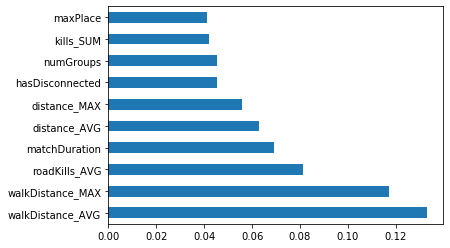

In [84]:
features_importances.nlargest(10).plot.barh()

## Evaluation

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

Accuracy = 0.71586


Per qualche motivo questo non funziona...

In [25]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.rdd.map(lambda x: (x.prediction, x.label))
metrics = MulticlassMetrics(predictionAndLabels)

In [ ]:
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [1.0, 2.0 ,3.0, 4.0, 5.0, 6.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

## Sklearn Evalutation

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [52]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           1       0.62      0.27      0.38      1353
           2       0.74      0.80      0.77     14097
           3       0.67      0.64      0.65     14286
           4       0.70      0.72      0.71     15104
           5       0.81      0.83      0.82     14552
           6       0.77      0.53      0.63      1390

    accuracy                           0.73     60782
   macro avg       0.72      0.63      0.66     60782
weighted avg       0.73      0.73      0.73     60782



In [53]:
print(confusion_matrix(y_true, y_pred))

[[  363   963    22     2     0     3]
 [  215 11268  2527    84     3     0]
 [    5  2889  9109  2218    59     6]
 [    0    60  2009 10831  2201     3]
 [    0     0    18  2280 12049   205]
 [    0     0     0     1   652   737]]
